In [36]:
import ast
#import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from PIL import Image
#import progressbar
import pydicom as dicom
#import pylibjpeg
import torch
import torch.optim as optim
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from typing import List, Tuple, Dict, Optional, Any
import pickle


In [37]:
#####################################
#
#     LOAD FROM FILES
#
#####################################
all_preds = None
all_gt_boxes = None
with open("all_preds.dat", "rb") as file:
    all_preds = pickle.load(file)
with open("all_gt_boxes.dat", "rb") as file:
    all_gt_boxes = pickle.load(file)
all_preds_df = pd.DataFrame(all_preds, columns=['image_id', 'pred_boxes', 'pred_scores'])    
all_preds_df = all_preds_df.sort_values('pred_scores',  ascending=False)
all_gt_boxes_ = np.array(all_gt_boxes).transpose()
print(all_gt_boxes_)

[[637 4541 4683 ... 4356 6214 6002]
 [array([0.20793338, 0.5504055 , 0.26484552, 0.61993045], dtype=float32)
  array([0.18916667, 0.582749  , 0.3441667 , 0.76043105], dtype=float32)
  array([0.2339897, 0.6208882, 0.3873576, 0.7878289], dtype=float32) ...
  array([0.11753675, 0.2       , 0.49918225, 0.9116667 ], dtype=float32)
  array([0.6738281 , 0.5887347 , 0.8776042 , 0.78910327], dtype=float32)
  array([0.22713311, 0.68795305, 0.5075659 , 0.9511926 ], dtype=float32)]
 [False False False ... False False False]]


In [38]:
all_preds_df.head()


,image_id,pred_boxes,pred_scores
174,4434,"[0.22300784, 0.31483668, 0.44160748, 0.6605542]",0.886809
139,4089,"[0.20123655, 0.27468762, 0.471412, 0.6843586]",0.881988
62,190,"[0.6027918, 0.07719615, 0.6027918, 0.65384793]",0.878890
183,4356,"[0.19988577, 0.1849271, 0.47664344, 0.75689673]",0.861582
152,2155,"[0.20381741, 0.10327816, 0.45341873, 0.6160154]",0.819639


In [39]:
#all_gt_boxes = np.array(all_gt_boxes).transpose()[0]

all_gt_boxes = all_gt_boxes_[:]

MIN_IOU = 0.5

#arrays for TP and FP         
nd = len(all_preds_df)
tp = [0] * nd # creates an array of zeros of size nd
fp = [0] * nd
all_gt_objects = [0] * nd
all_tp = 0
all_fp = 0

#for each detected objct (detected_box)
for i in range (len(all_preds_df)):
    img_id = all_preds_df.iloc[i]['image_id']
    pred_box = all_preds_df.iloc[i]['pred_boxes']

    #count true positives:
    # set temp_max_iou = -1
    # set temp_gt_match = -1

    iou_max = -1
    gt_match = -1
    gt_row = -1        
    
    #compare the detected_box with all gt_boxes for this image to find max IOU
        #for box in gt boxes of image:
                   
                                           
    '''
    for idx, row in gt_boxes_i.iterrows():
        bb_gt = row['gt_boxes']
        #print(bb_gt)
        bb_pred = pred['pred_boxes']
        used = row['used']

        #print(bb_pred)
        #print()
        #print(used)    
    '''
    #gt_boxes_i = all_gt_boxes[1][np.where(all_gt_boxes[0] == img_id)]
    #used_flag_i = all_gt_boxes[2][np.where(all_gt_boxes[0] == img_id)]
    
    for j in range (len(all_gt_boxes[0])):
        if all_gt_boxes[0][j] == img_id:
            all_gt_objects[i] += 1
            bb_gt = all_gt_boxes[1][j]
            used = all_gt_boxes[2][j]
            
            bb_pred = pred_box      
            
            if used == False:
                # calculate IOU

                intersect_box = [max(bb_pred[0],bb_gt[0]), max(bb_pred[1],bb_gt[1]), min(bb_pred[2],bb_gt[2]), min(bb_pred[3],bb_gt[3])]
                #print(intersect_box)
                intersect_w = intersect_box[2] - intersect_box[0] + 1
                intersect_h = intersect_box[3] - intersect_box[1] + 1
                if intersect_w > 0 and intersect_h >0:


                    union_area = (bb_pred[2] - bb_pred[0] + 1) * (bb_pred[3] - bb_pred[1] + 1) + (bb_gt[2] - bb_gt[0] + 1) * (bb_gt[3] - bb_gt[1] + 1) - intersect_w * intersect_h

                    iou_i = intersect_w * intersect_h / union_area
                    #print(iou_i)

                    # find max iou for this prediction
                    if iou_i > iou_max:
                        iou_max = iou_i
                        gt_match = pred_box  
                        iou_max_gt_box_idx = j
                        #print(iou_max)


    if iou_max >= MIN_IOU:
        #print('yes!')
        #set flag used to 'True'
        all_gt_boxes[2][iou_max_gt_box_idx] = True
        #used_flag_i = all_gt_boxes[2][np.where(all_gt_boxes[0] == img_id)]
        #all_gt_boxes_df.at[gt_row.name, 'used'] = True
        
        tp[i] = 1
        all_tp +=1
    else:
        fp[i] =1
        all_fp +=1    
    
    # fp and tp arrays are sorted in same order as dataframe with predictions  

    #calculate precision/recall
    #cumsum = 0
    

#add cols with cumsum of tp and fp cols
#add column rec: rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
#add column prec: prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

#ap, mrec, mprec = voc_ap(rec[:], prec[:])
#siehe unten weiter

print(all_tp)
print(all_fp)

146
39


In [40]:
def voc_ap(rec_, prec_):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    #rec.insert(0, 0.0) # insert 0.0 at begining of list
    #rec.append(1.0) # insert 1.0 at end of list
    mrec = np.concatenate([[0.0],rec_,[1.0]])
    
    
    
    #prec.insert(0, 0.0) # insert 0.0 at begining of list
    #prec.append(0.0) # insert 0.0 at end of list
    mpre = np.concatenate([[0.0],prec_ ,[0.0]])
    #print(prec_)
    
    
    
    
    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec

    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
   
    
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    #for i in range(len(mpre)-2, -1, -1):
        #mpre[i] = max(mpre[i], mpre[i+1])
    #for i in range(mpre.size - 1, 0, -1):
     #   mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    
    
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
    '''
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    '''

    
    return ap, mrec, mpre

In [41]:
#tp = tp[:5862]
#fp = fp[:5862]


sum_AP = 0

#rec = tp[:]
#for i in range (len(tp)):
    #rec[i] = float(tp[i]) / len(all_preds_df)
    
tp_cumsum = np.cumsum(tp, dtype=float)
all_gt_objects_cumsum = np.cumsum(all_gt_objects, dtype=float)
rec = tp_cumsum / all_gt_objects_cumsum

    
#prec = tp[:]
#for i in range (len(tp)):
    #prec[i] = float(tp[i]) / (fp[i] + tp[i])
fp_cumsum = np.cumsum(fp, dtype=float)
prec = tp_cumsum /(fp_cumsum + tp_cumsum)


    
class_name = 'opacity'
ap, mrec, mprec = voc_ap(rec[:], prec[:])

#print(mprec)

sum_AP += ap
text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)


print(text)
    
"""
rec = tp[:]
for idx, val in enumerate(tp):
    rec[idx] = float(tp[idx]) / len(all_preds_df)
#print(rec)
prec = tp[:]
for idx, val in enumerate(tp):
    prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
#print(prec)

ap, mrec, mprec = voc_ap(rec[:], prec[:])
sum_AP += ap
text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)

#Write to output.txt
"""

#add cols with cumsum of tp and fp cols
#add column rec: rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
#add column prec: prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

#ap, mrec, mprec = voc_ap(rec[:], prec[:])
#siehe unten weiter


48.74% = opacity AP 


'\nrec = tp[:]\nfor idx, val in enumerate(tp):\n    rec[idx] = float(tp[idx]) / len(all_preds_df)\n#print(rec)\nprec = tp[:]\nfor idx, val in enumerate(tp):\n    prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])\n#print(prec)\n\nap, mrec, mprec = voc_ap(rec[:], prec[:])\nsum_AP += ap\ntext = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)\n\n#Write to output.txt\n'

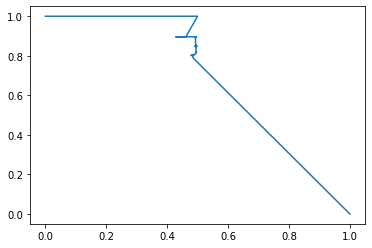

In [42]:
plt.plot(mrec, mprec)